<a href="https://colab.research.google.com/github/lokeshpara/samplegit/blob/S8/Eva_session8_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
%matplotlib inline
import matplotlib.pyplot as plt
import torchvision
import numpy as np
import torchvision.transforms as transforms

In [2]:
train_transform = transforms.Compose(
    [
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
    ]
)

test_transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
    ]
)

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=train_transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=test_transform)

SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)



# train dataloader
train_loader = torch.utils.data.DataLoader(trainset, **dataloader_args)



# test dataloader
test_loader = torch.utils.data.DataLoader(testset, **dataloader_args)



classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
CUDA Available? True


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


plane   dog  deer  deer


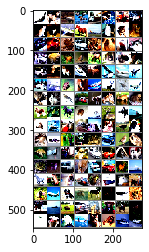

In [3]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

# get some random training images
dataiter = iter(train_loader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))

# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out





class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out


def ResNet18():
    return ResNet(BasicBlock, [2,2,2,2])

In [5]:

!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model = ResNet18().to(device)
summary(model, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
            Conv2d-3           [-1, 64, 32, 32]          36,864
       BatchNorm2d-4           [-1, 64, 32, 32]             128
            Conv2d-5           [-1, 64, 32, 32]          36,864
       BatchNorm2d-6           [-1, 64, 32, 32]             128
        BasicBlock-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
       BatchNorm2d-9           [-1, 64, 32, 32]             128
           Conv2d-10           [-1, 64, 32, 32]          36,864
      BatchNorm2d-11           [-1, 64, 32, 32]             128
       BasicBlock-12           [-1, 64, 32, 32]               0
           Conv2d-13          [-1, 128, 16, 16]          73,728
      BatchNorm2d-14          [-1, 128,

In [0]:
from tqdm import tqdm
train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, loss_func, epoch, l1=False):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = loss_func(y_pred, target)

    # L1 regularization
    if l1 == True:
      reg_loss = 0
      for param in model.parameters():
        reg_loss += torch.sum(abs(param))
      factor = 0.000002
      loss += factor * reg_loss

    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader, loss_func):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += loss_func(output, target).item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

In [7]:

model =  ResNet18().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.05, momentum=0.9, weight_decay=0) 

loss_func=nn.CrossEntropyLoss()
 
for epoch in range(50):
    print("Epoch:", epoch)
    train(model, device, train_loader, optimizer, loss_func, epoch, l1=False)
    # scheduler.step()
    test(model, device, test_loader, nn.CrossEntropyLoss(reduction='sum'))

  0%|          | 0/391 [00:00<?, ?it/s]

Epoch: 0


Loss=1.2364578247070312 Batch_id=390 Accuracy=39.82: 100%|██████████| 391/391 [00:29<00:00, 14.28it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 1.2992, Accuracy: 5198/10000 (51.98%)

Epoch: 1


Loss=1.055743932723999 Batch_id=390 Accuracy=60.84: 100%|██████████| 391/391 [00:28<00:00, 14.33it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.9682, Accuracy: 6547/10000 (65.47%)

Epoch: 2


Loss=0.7254070043563843 Batch_id=390 Accuracy=71.65: 100%|██████████| 391/391 [00:29<00:00, 14.61it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.8330, Accuracy: 7049/10000 (70.49%)

Epoch: 3


Loss=0.4457468092441559 Batch_id=390 Accuracy=78.11: 100%|██████████| 391/391 [00:29<00:00, 14.51it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.7727, Accuracy: 7387/10000 (73.87%)

Epoch: 4


Loss=0.37536996603012085 Batch_id=390 Accuracy=81.92: 100%|██████████| 391/391 [00:29<00:00, 14.44it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.6784, Accuracy: 7715/10000 (77.15%)

Epoch: 5


Loss=0.3615777790546417 Batch_id=390 Accuracy=84.88: 100%|██████████| 391/391 [00:29<00:00, 14.48it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.5355, Accuracy: 8110/10000 (81.10%)

Epoch: 6


Loss=0.434705913066864 Batch_id=390 Accuracy=87.25: 100%|██████████| 391/391 [00:29<00:00, 13.37it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.5247, Accuracy: 8234/10000 (82.34%)

Epoch: 7


Loss=0.2532418370246887 Batch_id=390 Accuracy=89.20: 100%|██████████| 391/391 [00:28<00:00, 14.45it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.5166, Accuracy: 8285/10000 (82.85%)

Epoch: 8


Loss=0.21719768643379211 Batch_id=390 Accuracy=90.65: 100%|██████████| 391/391 [00:29<00:00, 14.38it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.5349, Accuracy: 8327/10000 (83.27%)

Epoch: 9


Loss=0.4915100038051605 Batch_id=390 Accuracy=92.42: 100%|██████████| 391/391 [00:28<00:00, 13.64it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.5497, Accuracy: 8385/10000 (83.85%)

Epoch: 10


Loss=0.24525108933448792 Batch_id=390 Accuracy=93.39: 100%|██████████| 391/391 [00:28<00:00, 14.61it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.5239, Accuracy: 8431/10000 (84.31%)

Epoch: 11


Loss=0.12783880531787872 Batch_id=390 Accuracy=94.41: 100%|██████████| 391/391 [00:29<00:00, 14.55it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.5693, Accuracy: 8324/10000 (83.24%)

Epoch: 12


Loss=0.09112723171710968 Batch_id=390 Accuracy=95.16: 100%|██████████| 391/391 [00:29<00:00, 14.62it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.5416, Accuracy: 8559/10000 (85.59%)

Epoch: 13


Loss=0.07878614962100983 Batch_id=390 Accuracy=96.10: 100%|██████████| 391/391 [00:29<00:00, 14.67it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.5441, Accuracy: 8516/10000 (85.16%)

Epoch: 14


Loss=0.12164632230997086 Batch_id=390 Accuracy=96.62: 100%|██████████| 391/391 [00:29<00:00, 14.56it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.6172, Accuracy: 8502/10000 (85.02%)

Epoch: 15


Loss=0.051601022481918335 Batch_id=390 Accuracy=97.08: 100%|██████████| 391/391 [00:29<00:00, 14.68it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.6122, Accuracy: 8523/10000 (85.23%)

Epoch: 16


Loss=0.041012246161699295 Batch_id=390 Accuracy=97.42: 100%|██████████| 391/391 [00:29<00:00, 14.66it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.6192, Accuracy: 8541/10000 (85.41%)

Epoch: 17


Loss=0.013135815039277077 Batch_id=390 Accuracy=97.77: 100%|██████████| 391/391 [00:29<00:00, 14.67it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.6687, Accuracy: 8497/10000 (84.97%)

Epoch: 18


Loss=0.08483874797821045 Batch_id=390 Accuracy=98.15: 100%|██████████| 391/391 [00:28<00:00, 14.66it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.6068, Accuracy: 8601/10000 (86.01%)

Epoch: 19


Loss=0.02291090413928032 Batch_id=390 Accuracy=98.17: 100%|██████████| 391/391 [00:28<00:00, 14.56it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.7020, Accuracy: 8440/10000 (84.40%)

Epoch: 20


Loss=0.03017250820994377 Batch_id=390 Accuracy=98.57: 100%|██████████| 391/391 [00:28<00:00, 14.53it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.6600, Accuracy: 8581/10000 (85.81%)

Epoch: 21


Loss=0.024250995367765427 Batch_id=390 Accuracy=98.82: 100%|██████████| 391/391 [00:28<00:00, 14.67it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.7144, Accuracy: 8576/10000 (85.76%)

Epoch: 22


Loss=0.010995578952133656 Batch_id=390 Accuracy=98.75: 100%|██████████| 391/391 [00:29<00:00, 14.60it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.6692, Accuracy: 8596/10000 (85.96%)

Epoch: 23


Loss=0.01865839958190918 Batch_id=390 Accuracy=98.87: 100%|██████████| 391/391 [00:29<00:00, 14.56it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.6401, Accuracy: 8713/10000 (87.13%)

Epoch: 24


Loss=0.07360798120498657 Batch_id=390 Accuracy=99.16: 100%|██████████| 391/391 [00:29<00:00, 14.46it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.7000, Accuracy: 8632/10000 (86.32%)

Epoch: 25


Loss=0.0011172294616699219 Batch_id=390 Accuracy=99.14: 100%|██████████| 391/391 [00:28<00:00, 14.53it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.6959, Accuracy: 8640/10000 (86.40%)

Epoch: 26


Loss=0.022359883412718773 Batch_id=390 Accuracy=99.29: 100%|██████████| 391/391 [00:28<00:00, 14.59it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.7128, Accuracy: 8639/10000 (86.39%)

Epoch: 27


Loss=0.05482802540063858 Batch_id=390 Accuracy=99.39: 100%|██████████| 391/391 [00:29<00:00, 14.52it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.7366, Accuracy: 8684/10000 (86.84%)

Epoch: 28


Loss=0.003909087274223566 Batch_id=390 Accuracy=99.38: 100%|██████████| 391/391 [00:29<00:00, 14.70it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.7862, Accuracy: 8578/10000 (85.78%)

Epoch: 29


Loss=0.019195223227143288 Batch_id=390 Accuracy=99.22: 100%|██████████| 391/391 [00:29<00:00, 14.70it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.7297, Accuracy: 8631/10000 (86.31%)

Epoch: 30


Loss=0.01608518324792385 Batch_id=390 Accuracy=99.46: 100%|██████████| 391/391 [00:28<00:00, 14.83it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.7128, Accuracy: 8746/10000 (87.46%)

Epoch: 31


Loss=0.0019415616989135742 Batch_id=390 Accuracy=99.56: 100%|██████████| 391/391 [00:28<00:00, 14.74it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.7663, Accuracy: 8669/10000 (86.69%)

Epoch: 32


Loss=0.09936799108982086 Batch_id=390 Accuracy=99.41: 100%|██████████| 391/391 [00:28<00:00, 14.58it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.7132, Accuracy: 8696/10000 (86.96%)

Epoch: 33


Loss=0.005517554469406605 Batch_id=390 Accuracy=99.61: 100%|██████████| 391/391 [00:28<00:00, 14.53it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.7496, Accuracy: 8689/10000 (86.89%)

Epoch: 34


Loss=0.013895106501877308 Batch_id=390 Accuracy=99.60: 100%|██████████| 391/391 [00:29<00:00, 14.61it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.7454, Accuracy: 8719/10000 (87.19%)

Epoch: 35


Loss=0.025002658367156982 Batch_id=390 Accuracy=99.70: 100%|██████████| 391/391 [00:28<00:00, 14.56it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.7682, Accuracy: 8682/10000 (86.82%)

Epoch: 36


Loss=0.040706682950258255 Batch_id=390 Accuracy=99.64: 100%|██████████| 391/391 [00:29<00:00, 14.53it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.8043, Accuracy: 8652/10000 (86.52%)

Epoch: 37


Loss=0.009246480651199818 Batch_id=390 Accuracy=99.68: 100%|██████████| 391/391 [00:29<00:00, 14.51it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.7562, Accuracy: 8756/10000 (87.56%)

Epoch: 38


Loss=0.04869125038385391 Batch_id=390 Accuracy=99.63: 100%|██████████| 391/391 [00:29<00:00, 14.28it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.7880, Accuracy: 8665/10000 (86.65%)

Epoch: 39


Loss=0.009026646614074707 Batch_id=390 Accuracy=99.65: 100%|██████████| 391/391 [00:29<00:00, 14.63it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.7787, Accuracy: 8674/10000 (86.74%)

Epoch: 40


Loss=0.026981759816408157 Batch_id=390 Accuracy=99.64: 100%|██████████| 391/391 [00:29<00:00, 14.69it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.7852, Accuracy: 8678/10000 (86.78%)

Epoch: 41


Loss=0.015836000442504883 Batch_id=390 Accuracy=99.56: 100%|██████████| 391/391 [00:28<00:00, 14.48it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.7448, Accuracy: 8691/10000 (86.91%)

Epoch: 42


Loss=0.0017988085746765137 Batch_id=390 Accuracy=99.70: 100%|██████████| 391/391 [00:29<00:00, 14.67it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.7596, Accuracy: 8725/10000 (87.25%)

Epoch: 43


Loss=0.0019914270378649235 Batch_id=390 Accuracy=99.76: 100%|██████████| 391/391 [00:29<00:00, 14.53it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.8020, Accuracy: 8720/10000 (87.20%)

Epoch: 44


Loss=0.0016000985633581877 Batch_id=390 Accuracy=99.76: 100%|██████████| 391/391 [00:28<00:00, 14.68it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.7718, Accuracy: 8717/10000 (87.17%)

Epoch: 45


Loss=0.009819865226745605 Batch_id=390 Accuracy=99.79: 100%|██████████| 391/391 [00:29<00:00, 14.37it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.7623, Accuracy: 8730/10000 (87.30%)

Epoch: 46


Loss=0.018825769424438477 Batch_id=390 Accuracy=99.74: 100%|██████████| 391/391 [00:28<00:00, 14.47it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.7926, Accuracy: 8766/10000 (87.66%)

Epoch: 47


Loss=0.005781948566436768 Batch_id=390 Accuracy=99.69: 100%|██████████| 391/391 [00:29<00:00, 14.69it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.8097, Accuracy: 8723/10000 (87.23%)

Epoch: 48


Loss=0.00038530825986526906 Batch_id=390 Accuracy=99.74: 100%|██████████| 391/391 [00:29<00:00, 14.49it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.7614, Accuracy: 8746/10000 (87.46%)

Epoch: 49


Loss=0.0006007671472616494 Batch_id=390 Accuracy=99.89: 100%|██████████| 391/391 [00:29<00:00, 14.43it/s]



Test set: Average loss: 0.7715, Accuracy: 8731/10000 (87.31%)



Text(0.5, 1.0, 'Test Accuracy')

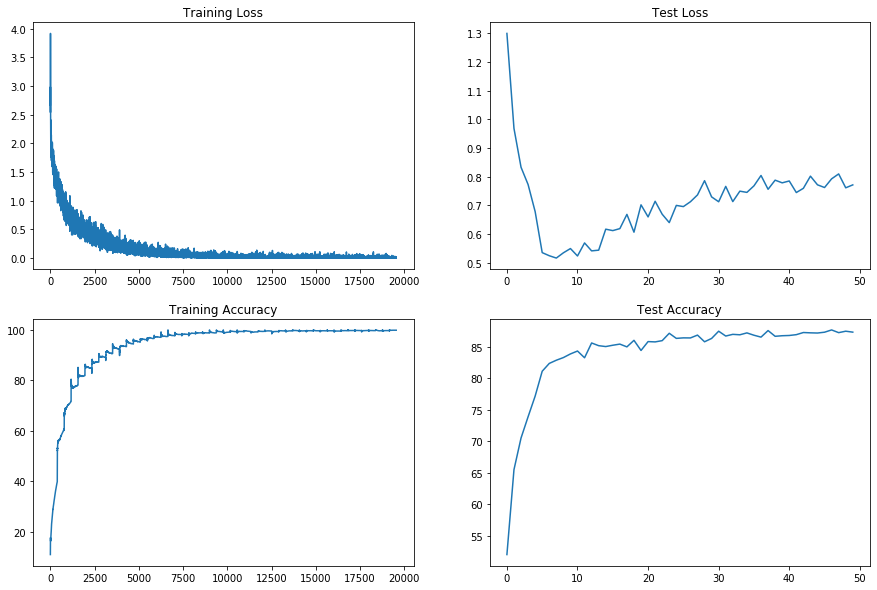

In [8]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")